In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-alexa-tsv/amazon_alexa.tsv


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk 
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
import pickle
import re 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data  = pd.read_csv(r"/kaggle/input/amazon-alexa-tsv/amazon_alexa.tsv" , delimiter='\t' , quoting=3) # quoting = 3 is ignore double quotes 
print(f"Dataset Shape : {data.shape}")

Dataset Shape : (3150, 5)


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
print(f"Feature Names : {data.columns.values}")

Feature Names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [6]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

Create a new column called Length which will contain the string length of the verified reviews column

In [7]:
data['verified_reviews'] = data['verified_reviews'].astype(str)


In [8]:
data['length']= data['verified_reviews'].apply(len) # counts spaces as well 


In [9]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [10]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

Analyzing the Ratings Column 

In [11]:
len(data)

3150

In [12]:
print(f"Ratings Value Count:\n {data['rating'].value_counts()} ")

Ratings Value Count:
 rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64 


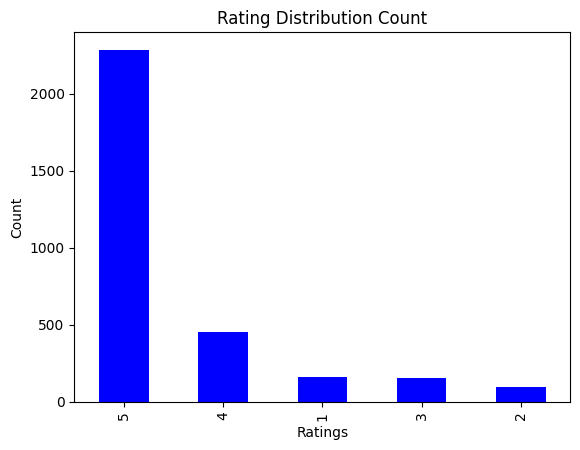

In [13]:
data['rating'].value_counts().plot.bar(color='blue')
plt.title("Rating Distribution Count")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

In [14]:
print(f"Ratings Percentage Distribution \n {round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Ratings Percentage Distribution 
 rating
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: count, dtype: float64


<Axes: ylabel='Percentage of Ratings'>

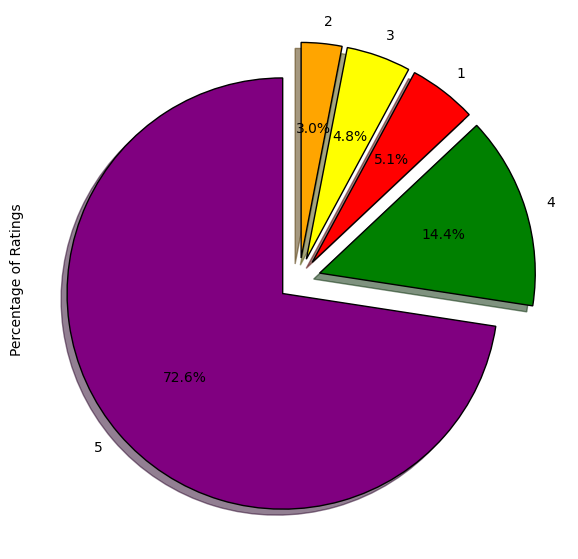

In [15]:
fig= plt.figure(figsize=(7,7))

colors =('purple','green','red','yellow','orange')
wp = {'linewidth':1 ,"edgecolor": 'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%" , shadow=True , colors = colors, startangle=90 , wedgeprops=wp , explode=explode, label="Percentage of Ratings")


Analyze Feedback Column 

In [16]:
print(f"Feedback value Count \n {data['feedback'].value_counts()}")

Feedback value Count 
 feedback
1    2893
0     257
Name: count, dtype: int64


In [17]:
review_1 = data[data['feedback']==1].iloc[16]['verified_reviews']
print(review_1)

Really happy with this purchase.  Great speaker and easy to set up.


In [18]:
review_2 = data[data['feedback']==0].iloc[18]['verified_reviews']
print(review_2)

Poor quality. Gave it away.


We can say that feedback 0 = negative and feedback 1 = positive

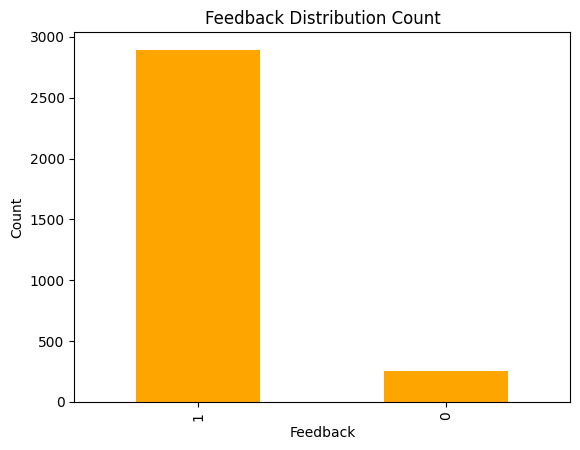

In [19]:
data['feedback'].value_counts().plot.bar(color='orange')
plt.title("Feedback Distribution Count")
plt.xlabel("Feedback")
plt.ylabel("Count")
plt.show()

In [20]:
print(f"Feedback Percentage Distribution \n {round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback Percentage Distribution 
 feedback
1    91.84
0     8.16
Name: count, dtype: float64


<Axes: ylabel='Percentage of Feedback'>

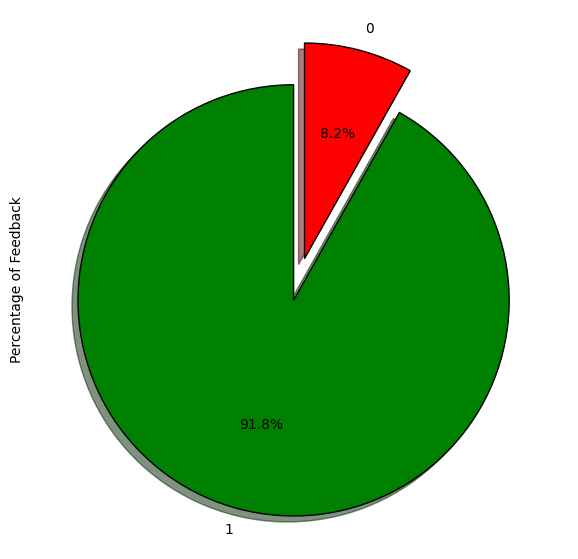

In [21]:
fig= plt.figure(figsize=(7,7))

colors =('green','red')
wp = {'linewidth':1 ,"edgecolor": 'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode = (0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%" , shadow=True , colors = colors, startangle=90 , wedgeprops=wp , explode=explode, label="Percentage of Feedback")



In [22]:
#Feedback =1 
print("Ratings and Feedback Counts (1):")
data[data['feedback']==1]['rating'].value_counts()

Ratings and Feedback Counts (1):


rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [23]:
#Feedback =0
print("Ratings and Feedback Counts (0):")
data[data['feedback']==0]['rating'].value_counts()

Ratings and Feedback Counts (0):


rating
1    161
2     96
Name: count, dtype: int64

In [24]:
print(f"Variation value Count: \n {data['variation'].value_counts()}")

Variation value Count: 
 variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


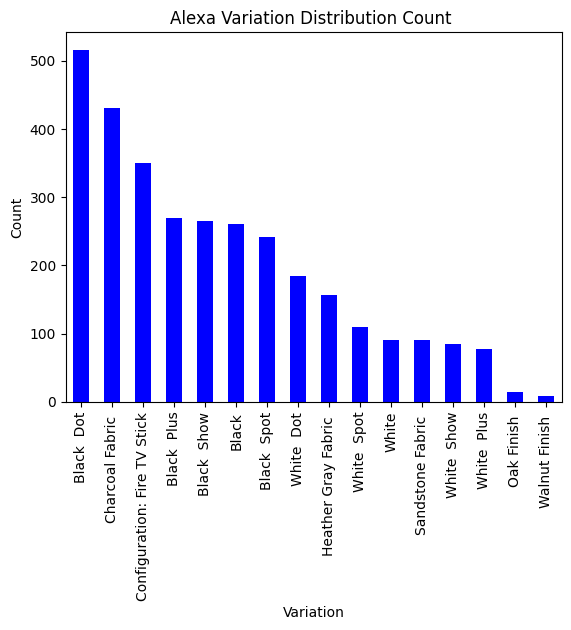

In [25]:
data['variation'].value_counts().plot.bar(color='blue')
plt.title("Alexa Variation Distribution Count ")
plt.xlabel("Variation")
plt.ylabel("Count")
plt.show()

In [26]:
print(f"Variation Percentage Distribution \n {round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation Percentage Distribution 
 variation
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [27]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

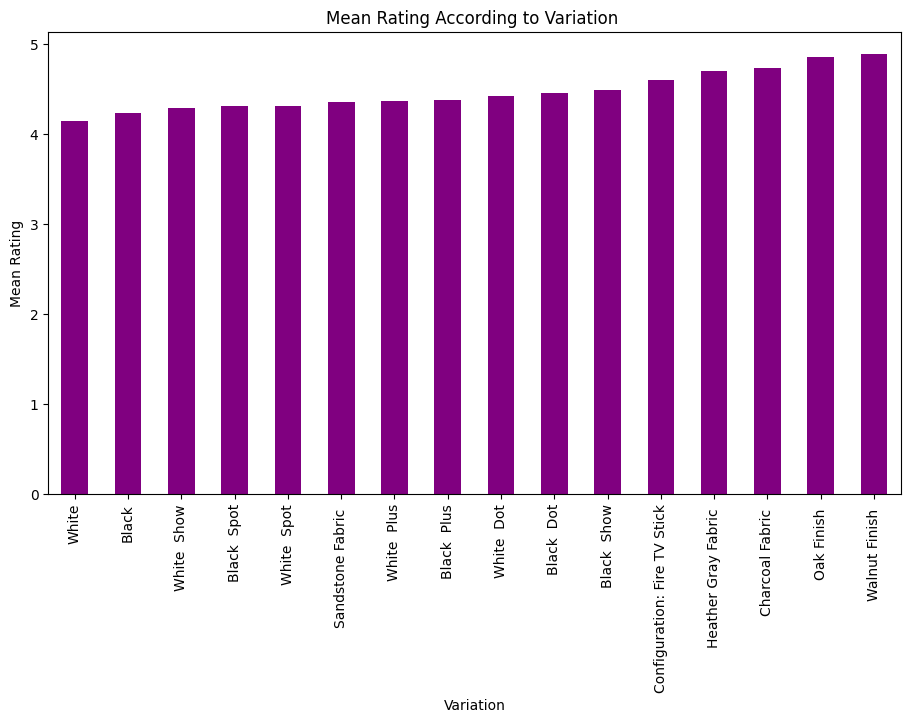

In [28]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'purple' , figsize=(11,6))
plt.title("Mean Rating According to Variation ")
plt.xlabel("Variation")
plt.ylabel("Mean Rating")
plt.show()

In [29]:
data['length'].describe()

count    3150.000000
mean      132.673333
std       182.527177
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of Length of Review')]

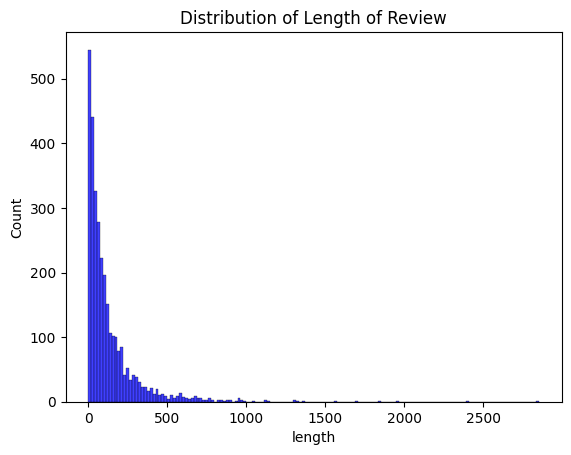

In [30]:
sns.histplot(data['length'] , color='blue').set(title = "Distribution of Length of Review")

[Text(0.5, 1.0, 'Distribution of Length of  Review If Feedback is 0')]

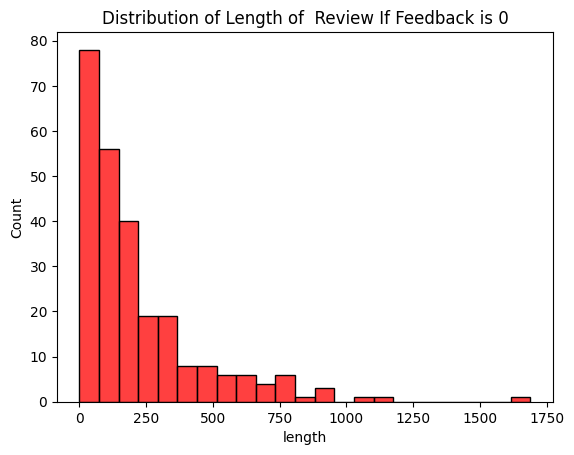

In [31]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title="Distribution of Length of  Review If Feedback is 0")

[Text(0.5, 1.0, 'Distribution of Length of  Review If Feedback is 1')]

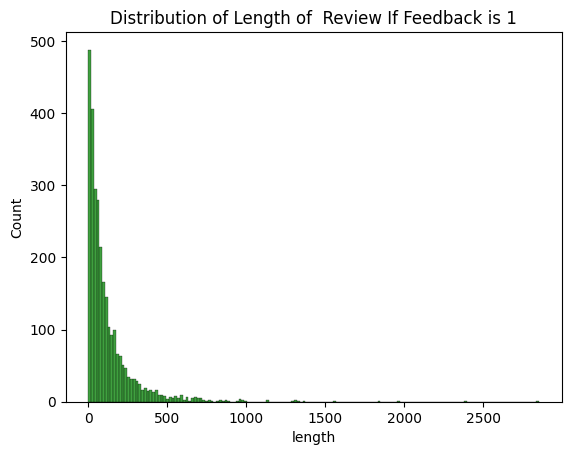

In [32]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title="Distribution of Length of  Review If Feedback is 1")

Length Wise Mean Rating 

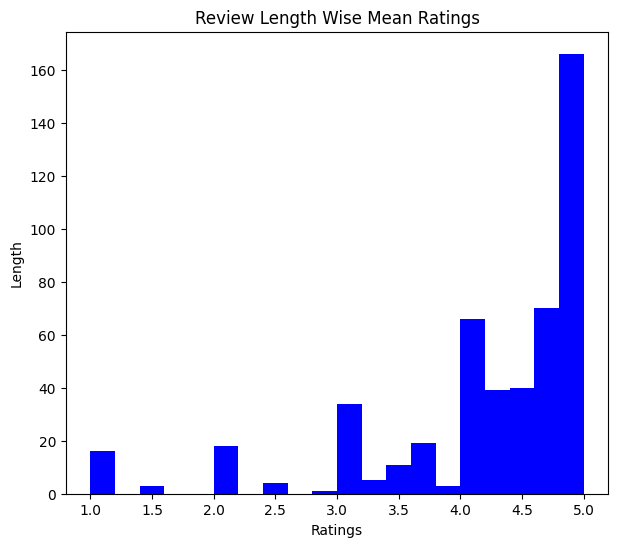

In [33]:
data.groupby('length')['rating'].mean().plot.hist(color='blue' , figsize=(7,6) , bins=20)
plt.title("Review Length Wise Mean Ratings")
plt.xlabel("Ratings")
plt.ylabel("Length")
plt.show()

In [34]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

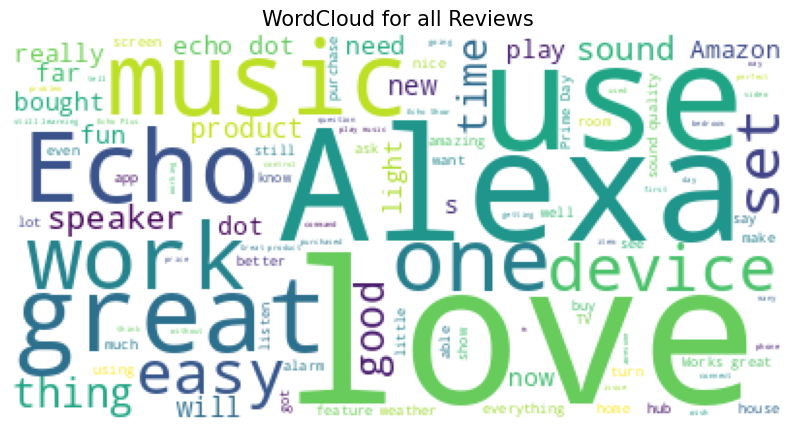

In [35]:
# combine all reviews 
reviews = " ".join([review for review in data['verified_reviews']])

wc = WordCloud(background_color='white' , max_words=100)


plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title("WordCloud for all Reviews" , fontsize =15)
plt.axis('off')
plt.show()

Find Unique Words 

In [36]:

# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

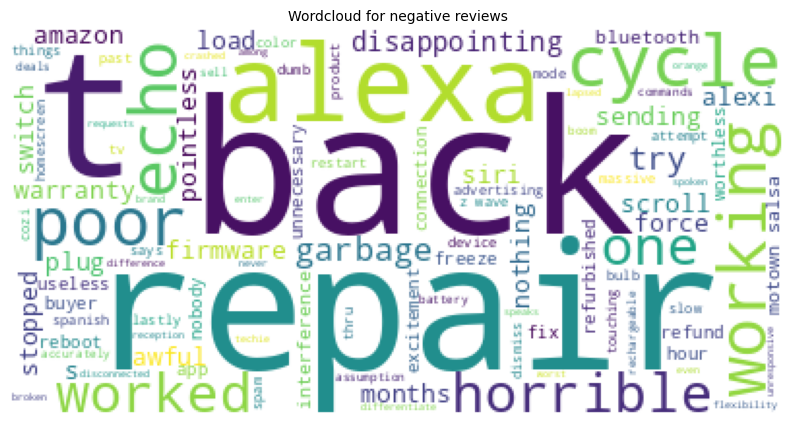

In [37]:
wc1 = WordCloud(background_color='white', max_words=100)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc1.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()


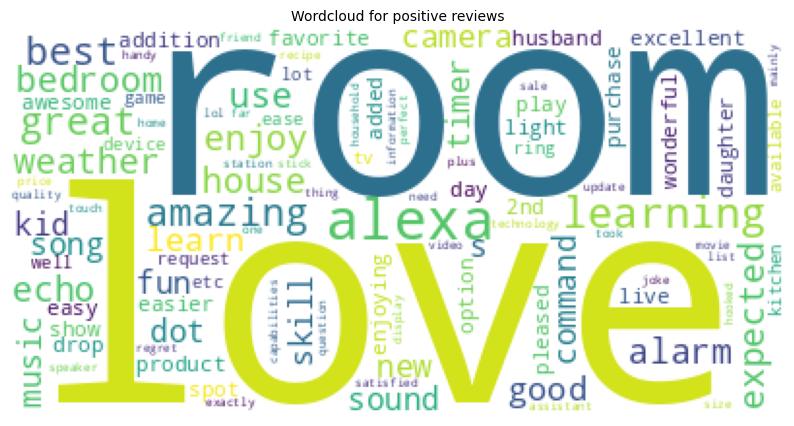

In [38]:
wc2 = WordCloud(background_color='white', max_words=100)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc2.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()


Preprocessing and Modelling 

In [39]:
corpus =[]
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]',' ' , data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [40]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [41]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3150, 2500)
y shape: (3150,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [43]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [44]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

Random Forest

In [45]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [46]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9386243386243386


In [47]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)


In [48]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 22  53]
 [  5 865]]


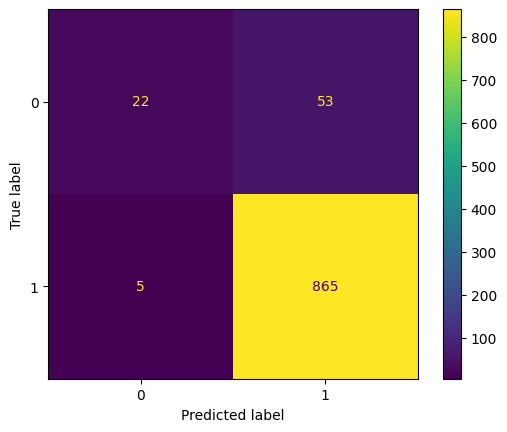

In [49]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K-Fold Cross Validation for Random Forest

In [50]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9374208144796381
Standard Variance : 0.011568643702928705


Grid Search for Optimal Parameters on Random Forest

In [51]:
params = {
    'bootstrap': [True], #replacement of sample 
    'max_depth': [80, 100], # longest path from the root 
    'min_samples_split': [8, 12], # min no of samples required to split internal node 
    'n_estimators': [100, 300]  #no of trees 
}

In [52]:
cv_object = StratifiedKFold(n_splits = 2) # 2 k folds 
grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True) # verbose = 0 means no ouput message 
grid_search.fit(X_train_scl, y_train.ravel())


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [53]:
#Getting the best parameters from the grid search
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [54]:

print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.91071557853273
Cross validation mean accuracy on test set : 92.30144688714
Accuracy score for test set : 0.9386243386243386


XGBoost

In [55]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))


Training Accuracy : 0.9700680272108844
Testing Accuracy : 0.9407407407407408


In [57]:
y_preds = model_xgb.predict(X_test)

In [58]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 25  50]
 [ 10 860]]


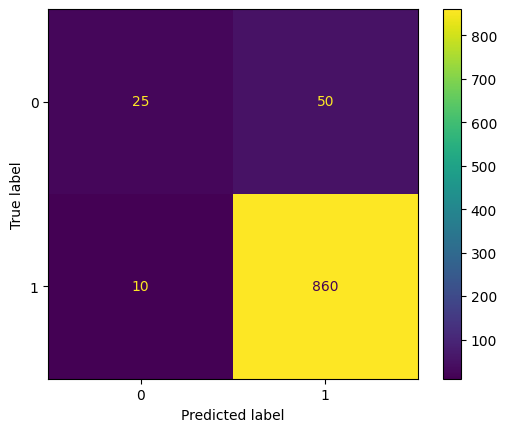

In [59]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

Decision Tree Classifier 

In [60]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [61]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9941043083900227
Testing Accuracy : 0.9153439153439153


In [62]:
y_preds = model_dt.predict(X_test)

In [63]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 39  36]
 [ 79 791]]


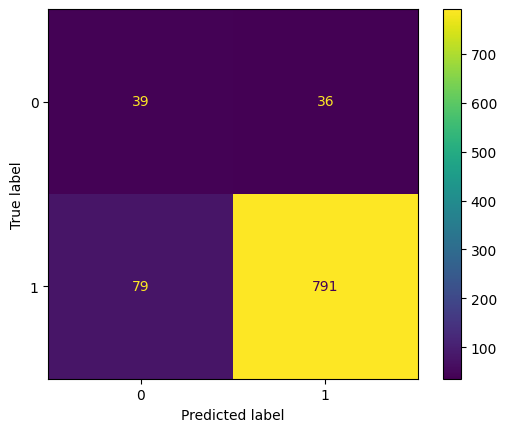

In [64]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()